# 🚀 Introduction
In the world of Large Language Models (LLMs) like ChatGPT, vector similarity search plays a crutial role in efficiently finding and retrieving information that is semantically relevant to a given query. This process is fundamental in applications such as semantic search, recommendation systems and natural language processing tasks where understanding the meaning and context of text is essential. 

In this notebook I will talk about different distance metrics and their background. 

But before we start let´s define some key terms. 

## ❓What is a Vector?

In machine learning, a vector is a fundamental data structure used to represent data in a multidimensional space. Vectors are used extensively in varous algorithms and porcesses, from data reprensation to model parameters. It is an array of numbers that can represent various types of information such as text, images or numerical values. 

## ❓ What are Embeddings?

Embeddings are a type of vector representation used primarily in machine learning and natural language processing (NLP) to map discrete objects, such as words or items, into continous vector spaces. These vectors, often referred to as embeddings capture semantic relationships and similarities between the objects in a way that makes them useful for various tasks like classification, clustering and recommendation. 

<img src='https://miro.medium.com/v2/resize:fit:4800/format:webp/1*dT3594m7X1N0zdZhydw2FA.png'/>
Source:<a href='https://towardsdatascience.com/exploring-the-power-of-embeddings-in-machine-learning-18a601238d6b'>The Power of Embeddings in Machine Learning by Rian Dolphin</a>

The image above showing how embeddings can capture relationships between words when visualised in lower dimensional space. 

Here are some key characteristics of Embeddings:
1. Dimensionality: Embeddings are represented as vectors in an contiuous space of fixed dimensions, such as 50, 100, 300 etc.
2. Semantic Similarity: Objects that are semantically similar or related tend to have embedding vectors that are close to each other in the vector space. 
3. Learning: Embeddings are learned from data using machine learning models, which means they can capture complex pattterns and relationships inherent in the data. 

# ⚙️ Distance Metrics

Distance metrics in vector spaces are mathematical measures used to quantify the similarity od dissimilarity between vectors. The metrics are fundamental in various applications, including machine learning, pattern recognition and clustering. Of course they also play a crucial role in RAG applications combined with LLM´s. Depending on the machine learning model used, the vectors can have more than 1000 dimensions. The `text-embedding-3-large` from OpenAI for example has `3072` dimensions. 

As the dimension growths also the time to calculate the similarity between two vectors grows. Some simialrity measures are more compute-heave than others. That might be a challenge for calculating distances between vectors with thousands of dimensions. 

Fortunately, there is a wide selection of string similarity algorithms, each with its own advantages and disadvantages. 

The following distance metrics will be discussed now:
- Cosine Similarity
- Dot Product
- Euclidean Distance
- Manhattan Distance (L1 Norm)
- Jaccard Similarity
- Hamming Distance

Before we start let´s quickly define some small fake vectors for whose we can later calculate the similarity. 

In this notebook we want to check the similarity between cities.
Each of the cities contains three features `[population in mio, average yearly temperature in °C, area in square km]`. The vector representation for the cities are the following:

- Toronto `[3, 9, 630]`
- New York `[9, 13, 789]`
- Moscow `[11, 0, 2510]`
- Munich `[2 ,8, 310]`
- Cape Town `[0.4, 17, 496]`
- Amsterdam `[0.9 ,10, 219]`
- Athens `[0.6, 18, 38]`

In [1]:
!pip install spacy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import plotly.graph_objects as go
import spacy
from sklearn.manifold import TSNE

In [3]:
toronto = [3, 9, 630]
new_york = [9, 13, 789]
moscow = [11, 0, 2510]
munich = [2, 8, 310]
cape_town = [0.4, 14, 496]
amsterdam = [0.9, 10, 219]
athens = [0.6, 18, 38]

Three dimensional data is still easy to visualize and interpret for the human eye. The following visualization shows the cities in a three dimensional space. 

In [4]:
cities = ["Toronto", "New York", "Moscow", "Munich", "Cape Town", "Amsterdam", "Athens"]
values = {
    "Toronto": [3, 9, 630],
    "New York": [9, 13, 789],
    "Moscow": [11, 0, 2510],
    "Munich": [2, 8, 310],
    "Cape Town": [0.4, 14, 496],
    "Amsterdam": [0.9, 10, 219],
    "Athens": [0.6, 18, 38],
}

x = [values[city][0] for city in cities]
y = [values[city][1] for city in cities]
z = [values[city][2] for city in cities]
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers+text',
    text=cities,
    marker=dict(
        size=10,
        color='blue',                
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Population in million',
        yaxis_title='Annual temperature in °C',
        zaxis_title='Area in square km'
    ),
    title="3D Scatter Plot of City",
    width=1000,
    height=1000
)
fig.show();

When selecting the cities, I tried to choose some that are very different from each other. The 3D scatter plot shows this quite well. Moscow can be distinguished very well from the other cities. Mainly because of its size and location. 

## 1️⃣ Cosine Similarity
In simple terms, the cosine similarity metric calculates the cosine of the angle between two vectors, which ranges from -1 to 1. A value of 1 indicates that the two vectors are identical, a value of 0 means the vectors are orthogonal (i.e. they are not similar), and a value of -1 idicates that the vectors are exact oppsites. 

Cosine similarity is advantageous because it is not affected by the magnitude of the vectors, only the direction. This makes it a robust measure of similarity for text data and other high-dimensional spaces.

Mathematically, cosine similarity calulates the cosine of the angle between two vectors. The formula for cosine similarity is:
$$cos(\theta) = \frac{A \cdot B}{\left \| A \right \|\left \| B \right \|}$$
where:
- $A \cdot B$ is the dot product of vectors $A$ and $B$
- $\left \| A \right \|$ is the magnitude (or length) of vector $A$
- $\left \| B \right \|$ is the magnitude (or length) of vector $B$
- $\theta$ is the angle between the two vectors

The dot product of two vectors $A$ and $B$ is calculated as:
$$A \cdot B = \sum_{i=1}^{n}A_{i}B{i}$$
where $A_{i}$ and $B_{i}$ are the components of vectors $A$ and $B$ respectively, and $n$ is the number of dimensions. 

The magnitude of a vector $A$ is given by:
$$\left \| A \right \| = \sqrt{\sum_{i=1}^{n}A^{2}_{i}}$$

Let´s calculate the cosine similarity between Munich and Amsterdam real quick. 

```
munich = [2, 8, 310]
amsterdam = [0.9, 10, 219]
```
$$A \cdot B = (2*0.9) + (8*10) + (310*219) = 67971.8$$

$$\left \| A \right \| = \sqrt{2^{2}+ 8^{2} + 310^{2}} = 310.07$$

$$\left \| B \right \| = \sqrt{0.9^{2}+ 10^{2} + 219^{2}} = 219.19$$

$$cosine_similarity(A,B)= \frac{67971.8}{\sqrt{310.07} * \sqrt{219.19}} = 1.00016$$

Given that consine similarity values range from -1 to 1, a value of approximately 1.00016 suggests that there might be a slight calculation or rounding error. However in practical term the value is pretty close to 1, indicating that the vectors are alomost similar. That makes a lot of sense to me. Munich and Amsterdam are very similar. At least if you only consider size, climate and number of inhabitants and ignore all other characteristics. 

Nevertheless, we check the similarity score again by having it calculated. 

In [5]:
A = np.array(munich)
B = np.array(amsterdam)
cosine = np.dot(A,B)/(norm(A)*norm(B))
print("Cosine Similarity between Munich and Amsterdam:", cosine)

Cosine Similarity between Munich and Amsterdam: 0.9998006567220649


We get the same results as calculated manually. Let´s try the extrema and compare Moscow and Cape Town. 

In [6]:
A = np.array(moscow)
B = np.array(cape_town)
cosine = np.dot(A,B)/(norm(A)*norm(B))
print("Cosine Similarity between Moscow and Cape Town:", cosine)

Cosine Similarity between Moscow and Cape Town: 0.9995954987454997


Huch, the score is again almost 1. Why?

Cosine similarity measues the angle between two vectors, not their magnitude.  This means that it focuses on the direction of the vectors rather than their length. Even if two cities have vastly different features in terms of magnitude, if their features scale similarly, they can still have a high cosine similarity. Cosine similarity might not be the best metric when dealing with features that have vastly different scales or when the magnitude of the vectors plays a crucial role in their comparison. 

For comparing cities based on features like population, mean temperature, and area, other distance metrics like Euclidean distance might provide more intuitive results.

Also note, if you work with normalized vectors, cosine similarity is equivalent to the inner product. 

## 2️⃣ Dot Product
The dot product, also known as the scalar product, is an algebraic operation that takes two equal-length sequences of numbers (usually vectors) and returns a single number. The dot product shows the alignment of two vectors. The dot product is negative if the vectors are oriented in different directions and positive if the vectors are orientied in the same direction. 

As already mentions in the cosine similarity section, the dot product is defined as:

$$A \cdot B = \sum_{i=1}^{n}A_{i}B{i}$$



In [7]:
A = np.array(munich)
B = np.array(amsterdam)
dot_prod = np.dot(A, B)
print("Dot Product between Munich and Amsterdam:", dot_prod)

Dot Product between Munich and Amsterdam: 67971.8


Since the dot product is positive, it means that the vectors are directed in the same direction. With a three-dimensional array, it is quite difficult to get a dot product between two cities that is negative. 

For demonstration purposes, let's define a fictitious city that has only negative features and calculate the dot product. 

In [8]:
gigacity = [-100, -100, -10000]
A = np.array(munich)
B = np.array(gigacity)
dot_prod = np.dot(A, B)
print("Dot Product between Munich and Gigacity:", dot_prod)

Dot Product between Munich and Gigacity: -3101000


And now we have a negative dot product which indicates oppsosite vectors. 

## 3️⃣ Euclidean Distance

Euclidean distance is one of the most commonly used metrics to measure the "straight-line" distance between two points in a multi-dimensional space. It's derived from the Pythagorean theorem and provides a way to quantify the distance between two points with coordinates in any dimensional space.

Euclidian distance is always non-negative, i.e. $distance(A,B) \geq 0$. The distance is zero if and only if the points $A$ and $B$ are identical. Also the distance from $A$ to $B$ is the same as the distance from $B$ to $A$. 

The Euclidian distance between two points $A$ and $B$ in an n-dimensional space is given by:

$$\sqrt{\sum_{i=1}^{n}(A_{i} - B_{i})^2}$$

Where $A_{i}$ and $B_{i}$ are the coordinates of the points $A$ and $B$ in the i-th dimension, respectively. 

So consider Munich ($A$) and Amsterdam ($B$) array again:

$$A=(x_{1},y_{1},z_{1}) = (2, 8, 310)$$ 
$$B=(x_{2},y_{2},z_{2}) = (0.9, 10, 219)$$

Calculate the difference and square each diffeernce:

$$ (x_{2} - x_{1}) = (0.9-2) = -1.1^{2} = -1.21$$
$$(y_{2} - y_{1}) = (10-8) = 2^{2} = 4$$
$$(z_{2} - z_{1}) = (219-310) = -91^{2} = -8281$$

Sum the squared difference and take the square root of the sum (we can use the absolute value):

$$1.21 + 4 + 8281 = \sqrt{8286.21}= 91.0286218725$$

Check our manual calculation again. 

In [9]:
A = np.array(munich)
B = np.array(amsterdam)
dist = np.linalg.norm(A - B)
print(f"Euclidean Distance between Munich and Amsterdam: {dist}")

Euclidean Distance between Munich and Amsterdam: 91.02862187246382


In [10]:
A = np.array(moscow)
B = np.array(cape_town)
dist = np.linalg.norm(A - B)
print(f"Euclidean Distance between Moscow and Cape Town: {dist}")

Euclidean Distance between Moscow and Cape Town: 2014.0765526662585


This time we have a much higher distance between Moscow and Cape Town. Munich and Amsterdam is much closer compared to the other two cities. 

The Euclidean distance has some major limitations:
- In high-dimensional spaces, Euclidean distance can become less meaningful due to the "curse of dimensionality". Distances between points tend to become more similar, reducing discriminative power. 
- If the features (dimensions) have different units or vastly different ranges, Euclidean distance can be misleading. It´s often necessary to normalize or standardize features before calculating the distance. 
- Since Euclidean distance squares the differences, it can be havily influences by outliers or large difference in certain dimensions. 

## 4️⃣ Manhattan Distance (L1 Norm)

Manhattan distance, also kown as L1 norm or taxicab distance, is a distance metrics used to measure the distance between two points in a grid-based system. Unlike Euclidean distance, which measures the shortest straight-line distance, Manhattan distance measures the distance by summing the absolute differences of their Cartesian coordinates. 

Mathematically the Manhattan distance between two points $A$ and $B$ in an n-dimensional space is defined as:

$$\sum_{i=1}^{n}\left | A_{i} - B_{i} \right |$$

where:

- $A = (A_{1}, A_{2}, ..., A_{n})$ and $B = (B_{1}, B_{2}, ..., B_{n})$ are the coordinates of the points $A$ and $B$ in the n-dimensional space
- $\left | A_{i} - B_{i} \right |$ is the absolute difference between the i-th coordinates of points $A$ and $B$. 

We calculate the Manhattan distance between Munich and Amsterdam again. 

$$A=(x_{1},y_{1},z_{1}) = (2, 8, 310)$$ 
$$B=(x_{2},y_{2},z_{2}) = (0.9, 10, 219)$$

Calculate the absolute differences:

- $\left | x_{2} - x_{1} \right | = \left | 0.9 - 2 \right | = 1.1$
- $\left | y_{2} - y_{1} \right | = \left | 10 - 8 \right | = 2$
- $\left | z_{2} - z_{1} \right | = \left | 219 - 310 \right | = 91$

And then sum those values $1.1 + 2 + 91 = 94.1$. Therefore the Manhattan distance between Munich and Amsterdam is 94.1

In [11]:
A = np.array(munich)
B = np.array(amsterdam)
print(f"Manhattan Distance between Munich and Amsterdam: {np.sum(np.abs(A - B))}")

Manhattan Distance between Munich and Amsterdam: 94.1


In [12]:
A = np.array(moscow)
B = np.array(cape_town)
print(f"Manhattan Distance between Moscow and Cape Town: {np.sum(np.abs(A - B))}")

Manhattan Distance between Moscow and Cape Town: 2038.6


## 5️⃣ Jaccard Similarity

Jaccard similarity, also known as the Jaccard index or Jaccard coefficient, is a measure of similarity between two sets. It is defined as the size of the intersection of the sets divided by the size of the union of the sets. The Jaccard similarity ranges from 0 to 1, where 0 means no similarity and 1 means identical sets.

For two sets $A$ and $B$, the Jaccard similarity $J(A,B)$ is given by:

$$J(A,B) = \frac{\left | A \cap B \right |}{\left | A \cup B \right |}$$

where:

- $\left | A \cap B \right |$ is the number of elements in the inersection of $A$ and $B$
- $\left | A \cup B \right |$ is the number of elements in the union of $A$ and $B$

Jaccard similarity is primarily designed for comparing sets or binary vectors, where it measures the overlap between two sets. Applying Jaccard similarity to numerical vectors is less straightforward, as it doesn't directly account for the magnitude of the elements, only their presence or absence. There are some approaches that Jaccard can work with numerical vectors but we will loose a lot of information due to some transformations. 

For numerical vectors, it is generally better to use similarity measures like cosine similarity, Euclidean distance or Manhattan distance, which are designed to handle the magnitude and continous nature of numerical data more appropriately. 

## 6️⃣ Hamming Distance

Hamming distance is a metric used to measure the difference between two strings of equal length. It is defined as the number of positions at which the corresponding symbols in the two strings are different. 

Mathematically, it can be represented as:

$$d_{H}(A,B) = \sum_{i=1}^{n}\delta (A_{i},B_{i})$$

where:
- $A$ and $B$ are the strings of length n
- $A_{i}$ and $B_{i}$ are the symbols at position $i$ in strings $A$ and $B$, respectively
- $\delta (A_{i},B_{i})$ is an indicator function that equals 1 if $A_{i} \neq B_{i}$ and 0 if $A_{i} = B_{i}$

Consider two strings, `A = 101101` and `B = 110110` the hamming distance is 4 because the strings differ in 4 positions. 

We can also apply the hamming distance to an numeric vector and count how many times the number at the current index differs from the other value. 

The distance between munich = `[2, 8, 310]` and amsterdam = `[0.9, 10, 219]` is 3. 

The distance between moscow = `[11, 0, 2510]` and cape_town = `[0.4, 14, 496]` is also 3. 

Also the Hamming distance has some serious downsides. It is only defined for vectors of equal length. If the vectors are of different length, they must be padded or truncated to the same length before computing the distance. Hamming distance only counts the number of differing positions and does not account for the magnitude of differences. For numeric data where the magnitude of difference is important, other metrics are more appropriate. 

# ⏭️ One Step further

In the upper sections, we have worked with very simple three-dimensional vectors for easy calculation of the values. 

As I said at the beginning of the notebook, embeddings have far more than these three dimensions. These can go well into the hundreds and can no longer be represented so easily. 

In this section we work with real vectors. Once again, I'll simply try to visualize the concept of embeddings. We use [SpaCy](https://spacy.io/) for this. 

SpaCy is an open-source software library for advanced natural language processing (NLP) in Python. It's designed specifically for production use and provides a variety of features and tools to handle different aspects of NLP tasks. Here are some key aspects of SpaCy:

- Tokenization: Breaking down text into individual tokens (words, punctuation, etc.).
- Part-of-Speech (POS) Tagging: Assigning grammatical categories (like noun, verb, adjective) to each token.
- Named Entity Recognition (NER): Identifying and classifying named entities (like people, organizations, locations) in the text.
- Dependency Parsing: Analyzing the grammatical structure of a sentence and establishing relationships between words.
- Lemmatization: Reducing words to their base or root form.
- Sentence Boundary Detection (SBD): Identifying sentence boundaries in the text.
- Word Vectors and Similarity: Using pre-trained word vectors to compute similarities between words or phrases.
- Text Classification: Categorizing text into predefined labels or categories.

SpaCy is known for its high performance and efficiency, making it suitable for real-world applications that require processing large volumes of text quickly.

In our case, only the pre-trained vectors are of interest. 

In [13]:
# Some random words
words = [
    'cat', 'dog', 'fish', 'kitten', 'man', 'woman', 'king', 'queen', 'doctor', 'nurse',
    'apple', 'banana', 'orange', 'grape', 'strawberry', 'car', 'bus', 'train', 'bicycle', 'airplane',
    'computer', 'laptop', 'phone', 'tablet', 'mouse', 'keyboard', 'television', 'radio', 'book', 'magazine',
    'student', 'teacher', 'professor', 'school', 'university', 'scientist', 'engineer', 'lawyer', 'judge', 'police',
    'house', 'apartment', 'building', 'city', 'village', 'forest', 'river', 'mountain', 'beach', 'desert',
    'love', 'hate', 'happy', 'sad', 'angry', 'excited', 'bored', 'tired', 'hungry', 'thirsty',
    'run', 'jump', 'swim', 'walk', 'fly', 'drive', 'write', 'read', 'sing', 'dance',
    'cat', 'dog', 'bird', 'fish', 'elephant', 'lion', 'tiger', 'bear', 'wolf', 'fox',
    'flower', 'tree', 'grass', 'bush', 'leaf', 'root', 'stem', 'petal', 'seed', 'fruit',
    'bread', 'butter', 'cheese', 'milk', 'egg', 'meat', 'chicken', 'fish', 'rice', 'pasta',
    'morning', 'afternoon', 'evening', 'night', 'day', 'week', 'month', 'year', 'today', 'tomorrow',
    'horse', 'cow', 'pig', 'sheep', 'goat', 'chicken', 'duck', 'goose', 'turkey', 'rabbit',
    'lion', 'tiger', 'cheetah', 'leopard', 'jaguar', 'panther', 'hyena', 'wolf', 'fox', 'bear',
    'whale', 'dolphin', 'shark', 'octopus', 'squid', 'lobster', 'crab', 'shrimp', 'jellyfish', 'starfish',
    'eagle', 'hawk', 'falcon', 'owl', 'parrot', 'penguin', 'flamingo', 'sparrow', 'robin', 'canary',
    'rose', 'lily', 'tulip', 'daisy', 'sunflower', 'orchid', 'poppy', 'violet', 'lavender', 'daffodil',
    'oak', 'pine', 'birch', 'maple', 'willow', 'cedar', 'spruce', 'fir', 'cypress', 'redwood',
    'carrot', 'potato', 'tomato', 'cucumber', 'lettuce', 'spinach', 'broccoli', 'cauliflower', 'pepper', 'onion',
    'pizza', 'burger', 'sandwich', 'salad', 'soup', 'steak', 'pasta', 'sushi', 'taco', 'burrito',
    'piano', 'guitar', 'violin', 'drums', 'flute', 'trumpet', 'saxophone', 'clarinet', 'cello', 'harp',
    'winter', 'spring', 'summer', 'fall', 'autumn', 'snow', 'rain', 'sun', 'cloud', 'storm'
]

In [14]:
# Load the biggest english model from SpaCy
nlp = spacy.load("en_core_web_lg")
# Create embeddings using SpaCy
embeddings = np.array([nlp(word).vector for word in words])

In [15]:
print(f'Number of dimensions per word vector: {len(embeddings[0])}')

Number of dimensions per word vector: 300


With the SpaCy large model we will get 300 dimensional word embeddings. Since we can not visualize data in such spaces, we can use t-distributed stochastic neighbor embedding (tSNE) to convert high-dimensional data into low-dimensional spaces. 

In [16]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

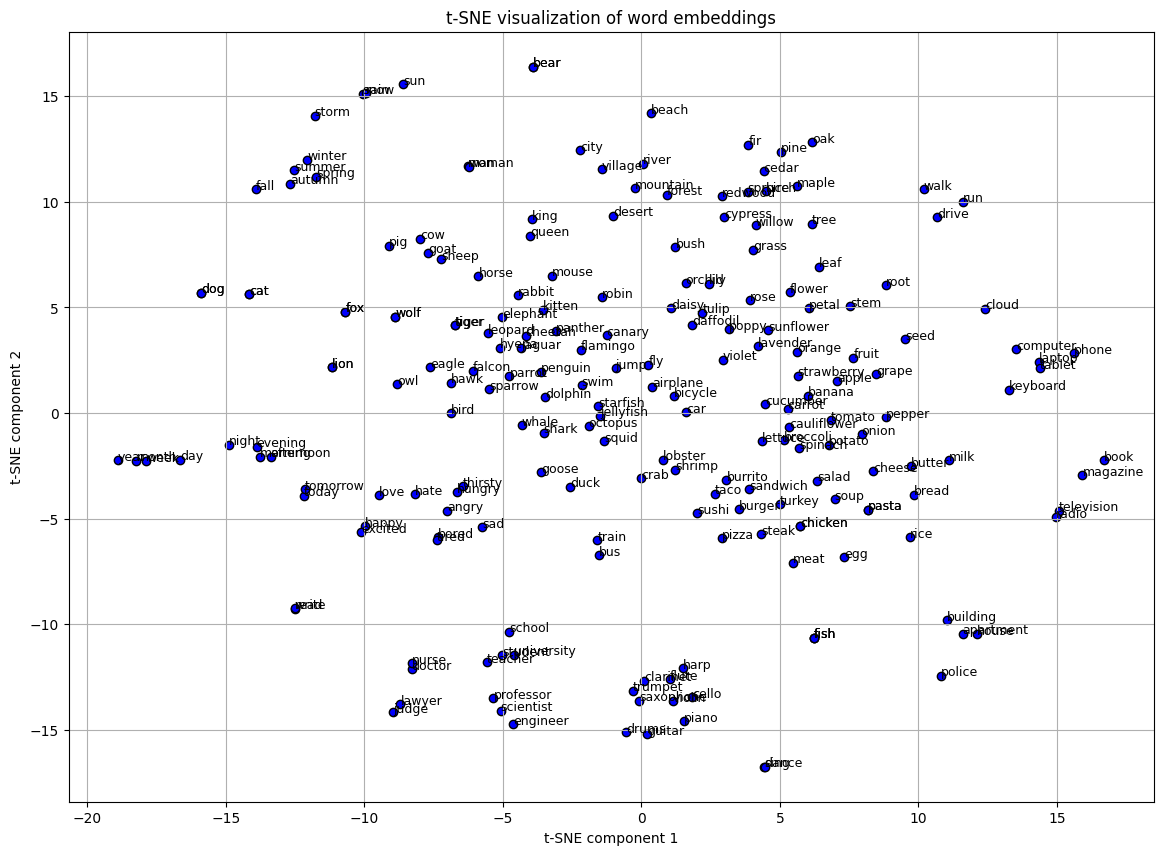

In [17]:
plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', edgecolor='k')

for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title('t-SNE visualization of word embeddings')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.grid(True)
plt.show();

The labeling in the plot makes it a bit confusing. Let's take a look at the point cloud at approx. (14,2.5) :
- Computer
- Phone
- Laptop
- tablet
- Keyboard

All terms have a certain similarity. Just take a little time to look at the diagram, I think it's self-explanatory. 

In comparison to the 'en_core_web_lg', there are far more powerful embedding models. 

The [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) from Huggingface provides a good overview of the various models. But always keep in mind, while higher-dimensional embeddings can potentially capture more complex relationships and patterns in the data, it does not always mean that the model is better. The choice of the embeddings depends on the specific task and dataset. 

Increasing the dimensionality can lead to higher computational complexity and memory requirements. It can also make the model more prone to overfitting, especially if the data is not large enough to support a high-dimensional representation.

Moreover, in some cases, lower-dimensional embeddings may be sufficient for capturing the relevant information in the data and may even improve the interpretability of the model. It is important to find a balance between the complexity of the model and the performance on the task at hand when deciding on the dimensionality of embeddings.

# ❓How to choose a Distance Metric?
We discusses six different distance metrics, so which one is the best to use? As always the appropriate distance metrics depends on the nature of your data and the embedding space you are working with. 

Given that RAG systems often deal with high-dimensional text embeddings, cosine similarity is generally a strong choice because it measures the similarity in direction, which is very important for text embeddings. However if you are working with other types of data consider the following:

- **Text Data:** Use cosine similarity or dot product similarity
- **Numerical Data:** Use Euclidean distance or Manhattan distance, depending on wheather the data is dense or sparse. 
- **Binary Data:** Use Jaccard or Hamming similarity

# 🔚 The End

**One last advise: Experiment with different metrics to see which yields the best retrieval performance for your specific use case**

I hope you enjoyed my short introduction to Distance Metrics in Vector Searches. If it was helpful, I would appreciate an upvote and a comment. ❤️